In [33]:
import numpy as np
from matplotlib import pyplot as plt
from pygenn import genn_model, genn_wrapper

In [34]:
# Load MNIST data (pre-normalized and coverted to numpy format)
training_images = np.load("training_images.npy")
training_labels = np.load("training_labels.npy")


### Visualize training data

(60000, 784)


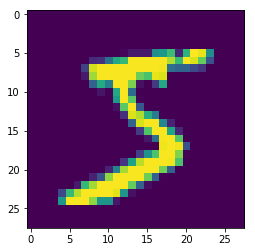

In [62]:
print(training_images.shape)
assert np.allclose(np.sum(training_images, axis=1), 1.0)

fig, axis = plt.subplots()
axis.imshow(np.reshape(training_images[0], (28, 28)))

### Parameters

In [36]:
DT = 0.02
INPUT_SCALE = 400.0
NUM_PN = 784
PRESENT_TIME_MS = 20.0

# **TODO** 
PN_PARAMS = {
    "C": 1.0,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 100.0}

# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}


### Custom models

In [37]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = genn_model.create_custom_current_source_class(
    "cs_model",
    var_name_types=[("magnitude", "scalar")],
    injection_code="$(injectCurrent, $(magnitude));")

neuron_reset_model = genn_model.create_custom_custom_update_class(
    "neuron_reset",
    param_names=["Vreset"],
    var_refs=[("V", "scalar"), ("RefracTime", "scalar")],
    update_code="""
    $(V) = $(Vreset);
    $(RefracTime) = 0.0;
    """)

### Model definition

In [52]:
# Create model
model = genn_model.GeNNModel("float", "mnist_mb")
model.dT = DT
model._model.set_seed(1337)

# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)

# Turn on spike recording
pn.spike_recording_enabled = True

# Create current sources to deliver input to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})

# Create custom updates to reset neuron parameter
pn_reset = model.add_custom_update("pn_reset", "ResetNeurons", neuron_reset_model,
                                   {"Vreset": PN_PARAMS["Vreset"]}, {}, 
                                   {"V": genn_model.create_var_ref(pn, "V"), "RefracTime": genn_model.create_var_ref(pn, "RefracTime")})


In [53]:
# Concert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

1.0
1.0
1.0
1.0


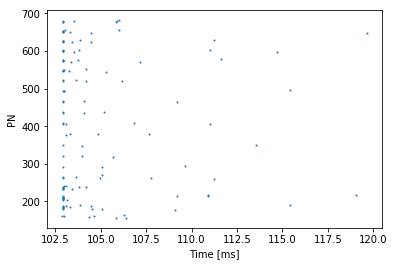

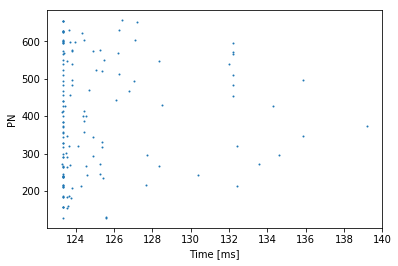

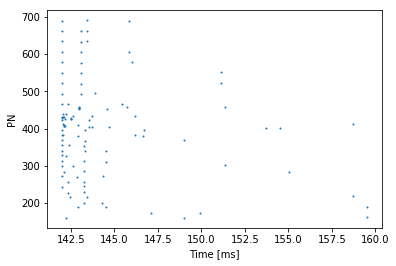

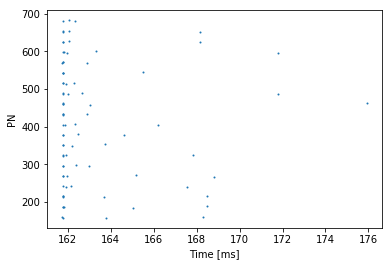

In [59]:
pn_input_current_view = pn_input.vars["magnitude"].view
for i in range(4):
    # Set training image
    pn_input_current_view[:] = training_images[i] * INPUT_SCALE
    pn_input.push_var_to_device("magnitude")

    # Simulate timesteps
    for i in range(present_timesteps):
        model.step_time()

    # Run the custom update used to reset neuron state
    model.custom_update("ResetNeurons")

    # Download spikes from GPI
    model.pull_recording_buffers_from_device();

    # Plot
    fig, axis = plt.subplots()
    pn_spike_times, pn_spike_ids = pn.spike_recording_data
    axis.scatter(pn_spike_times, pn_spike_ids, s=1)
    axis.set_xlabel("Time [ms]")
    axis.set_ylabel("PN")
plt.show()